In [60]:
import pandas as pd
from tqdm import tqdm
import re
import sentencepiece as spm
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import pickle
from collections import Counter
# function for removing emojis in texts
import emoji
# import sentencepiece tokenizer
import sys
!{sys.executable} -m pip install sentencepiece

## Helper Method for Preprocessing Tweets (texts)

In [28]:
# remove emojis, line carriage, @, and links from text
def dirtyRemoval(text):
    # remove emojis in texts
    temp = emoji.get_emoji_regexp().sub(u'', text)
    # merge multiple lines
    temp = temp.replace("\n", "")
    # remove '@'
    temp = re.sub(r'\@\w+\s', '', temp)
    # remove links
    temp = re.sub(r"http\S+", "", temp)
    return temp

In [42]:
temp1 = """RT @Hitz1039Fm: #MusikBox  🔥 w/ @andydosty #DostyMan 🇬🇭

▶️  I BELIEVE – @ANDYDOSTY  🎧

cc: @MrHaglah @MawuWan @FlyNimaBoy 💯 #Hitz1039FM 📢"""

print(dirtyRemoval(temp1))

RT @Hitz1039Fm: #MusikBox   w/ #DostyMan ️  I BELIEVE –  cc:  #Hitz1039FM 


## Preprocess test set texts, and merge files

In [40]:
# test set
id_text = pd.read_csv('../data/full_test_id_text.csv', sep='\t', header=[0], lineterminator='\n')
id_text.columns = ['ID', 'TEXT']

id_emoji = pd.read_csv('../data/full_test_plaintext.txt', sep='\t', header=[0], lineterminator='\n')
id_emoji.columns = ['ID','EMOJI']

print(len(id_text))
print(len(id_emoji))

572095
1000000


In [41]:
print(type(id_emoji.ID.iloc[10]))
print(type(id_text.ID.iloc[10]))
id_text['ID'] = id_text['ID'].apply(str)

<class 'str'>
<class 'numpy.int64'>


In [42]:
# inner join the two dataframes
text_emoji = pd.merge(id_text, id_emoji, on="ID", how="inner")

print(len(text_emoji))

572095


In [43]:
text_emoji['TEXT'] = text_emoji.TEXT.apply(dirtyRemoval)

In [44]:
text_emoji.to_csv('../data/text_emoji_test.txt', index=False)

## Preprocess validation set texts, and merge files

In [45]:
# validation set
id_text = pd.read_csv('../data/full_valid_id_text.csv', sep='\t', header=[0], lineterminator='\n')
id_text.columns = ['ID', 'TEXT']
id_text['ID'] = id_text['ID'].apply(str)

id_emoji = pd.read_csv('../data/full_valid_plaintext.txt', sep='\t', header=[0], lineterminator='\n')
id_emoji.columns = ['ID','EMOJI']

print(len(id_text))
print(len(id_emoji))

571932
1000000


In [46]:
text_emoji = pd.merge(id_text, id_emoji, on="ID", how="inner")
print(len(text_emoji))
text_emoji['TEXT'] = text_emoji.TEXT.apply(dirtyRemoval)
text_emoji.to_csv('../data/text_emoji_valid.txt', index=False)

571932


## Preprocess training set texts, and merge files

In [47]:
# training set
id_text = pd.read_csv('../data/full_train_id_text.csv', sep='\t', header=[0], lineterminator='\n')
id_text.columns = ['ID', 'TEXT']
id_text['ID'] = id_text['ID'].apply(str)

id_emoji = pd.read_csv('../data/full_train_plaintext.txt', sep='\t', header=[0], lineterminator='\n')
id_emoji.columns = ['ID','EMOJI']


print(len(id_text))
print(len(id_emoji))

7443390
12997219


In [49]:
text_emoji = pd.merge(id_text, id_emoji, on="ID", how="inner")
print(len(text_emoji))
text_emoji['TEXT'] = text_emoji.TEXT.apply(dirtyRemoval)
text_emoji.to_csv('../data/text_emoji_train.txt', index=False)

7443390


## Tokenizing texts using SentencePiece

In [50]:
# text for training tokenizer
with open('../data/text_train.txt', 'w') as f:
    for item in text_emoji['TEXT'].tolist():
        f.write("%s\n" % item)


In [51]:
# train the SentencePiece tokenizer

spm.SentencePieceTrainer.Train('--input=../data/text_train.txt --model_prefix=tokenizer --vocab_size=32000')


True

In [59]:
# load tokenizer
tokenizer = spm.SentencePieceProcessor()
tokenizer.Load('./tokenizer.model')
print(tokenizer.GetPieceSize())

32000


In [102]:
# tokenize training set texts
train = pd.read_csv('../data/text_emoji_train.txt', sep=',', header=[0], lineterminator='\n')
train.columns = ['ID', 'TEXT', 'EMOJI']
train['TEXT'] = train.TEXT.apply(str)
train['TEXT_ID'] = train.TEXT.apply(tokenizer.EncodeAsIds)
train.to_csv('../data/train.txt', index=False)

In [62]:
train.columns = ['ID', 'TEXT', 'EMOJI', 'TEXT_ID']
print(train['TEXT_ID'])
# check sentence length statistics
tempList = train.TEXT_ID.tolist()
lengthList = [len(i) for i in tempList]
maxLength = max(lengthList)
minLength = min(lengthList)
avgLength = sum(lengthList)/len(lengthList)
print(maxLength, minLength, avgLength)



0          [445, 8, 858, 11, 137, 1518, 6, 31977, 27, 618...
1          [12, 9, 11790, 38, 584, 15612, 13, 1178, 3166,...
2                    [7190, 94, 8, 53, 194, 6591, 249, 4371]
3                           [3, 163, 571, 65, 21, 4, 5, 249]
4          [12, 9, 15, 11407, 228, 584, 9906, 13, 3047, 6...
5          [78, 709, 56, 25, 1188, 10, 191, 4, 15, 53, 18...
6          [158, 727, 241, 33, 106, 48, 139, 4499, 103, 4...
7                     [1838, 3807, 873, 26, 14, 315, 80, 10]
8             [480, 5493, 479, 337, 142, 3027, 8, 672, 2496]
9          [12, 9, 16653, 11230, 16426, 13, 2956, 283, 6,...
10         [12, 9, 3342, 89, 6272, 5833, 13, 78, 4204, 18...
11         [12, 9, 22210, 5, 11211, 13, 52, 3, 88, 8, 60,...
12                      [3, 124, 7, 8, 129, 7, 31, 1058, 74]
13                    [233, 1402, 4648, 184, 40, 2262, 3191]
14         [623, 143, 386, 357, 469, 311, 15, 123, 292, 1...
15         [9388, 100, 8, 891, 1842, 906, 104, 1792, 1819...
16                      

(array([2.40000e+01, 2.00000e+00, 2.47500e+03, 4.48230e+04, 6.17460e+04,
        3.01630e+04, 3.08000e+04, 4.98260e+04, 9.61360e+04, 8.62980e+04,
        7.82000e+04, 6.94910e+04, 7.61340e+04, 9.32690e+04, 9.53520e+04,
        8.26340e+04, 8.21030e+04, 9.15740e+04, 1.03467e+05, 9.53580e+04,
        9.04550e+04, 8.71460e+04, 9.08660e+04, 9.03470e+04, 8.71680e+04,
        8.41850e+04, 8.52920e+04, 8.56450e+04, 8.43810e+04, 8.19840e+04,
        8.05800e+04, 7.94750e+04, 8.03780e+04, 7.96910e+04, 7.84230e+04,
        7.71370e+04, 7.75310e+04, 7.64900e+04, 7.73480e+04, 7.55360e+04,
        7.46540e+04, 7.73190e+04, 7.38970e+04, 7.41280e+04, 7.36820e+04,
        7.24190e+04, 7.16070e+04, 7.14340e+04, 7.10990e+04, 6.96590e+04,
        6.86430e+04, 6.81470e+04, 6.66610e+04, 6.65430e+04, 6.57070e+04,
        6.39360e+04, 6.32800e+04, 6.20750e+04, 6.17470e+04, 6.05240e+04,
        5.99960e+04, 5.88300e+04, 5.78430e+04, 5.70110e+04, 5.53320e+04,
        5.40220e+04, 5.37220e+04, 5.28960e+04, 5.25

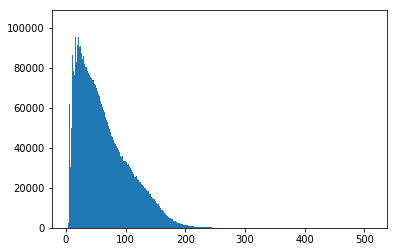

In [63]:
plt.hist(lengthList, bins=np.arange(minLength, maxLength+1))

## Encode class labels using LabelEncoder

In [9]:
# get all classes from training set
# train = pd.read_csv('../data/train.txt', sep=',', header=[0], lineterminator='\n')
# train.columns = ['ID', 'TEXT', 'EMOJI', 'TEXT_ID']
emoji_set = set()
for i in train['EMOJI'].tolist():
    emoji_set = emoji_set.union(set(i.split(',')))
    
print(len(emoji_set))

1300


In [28]:
# encode multi-class labels

le = preprocessing.LabelEncoder()

emoji_list = list(emoji_set)
le.fit(emoji_list)

len(le.classes_)


1300

In [29]:
# save the label encoder using pickle

with open('labelEncoder.pickle', 'wb') as handle:
    pickle.dump(le, handle, protocol=pickle.HIGHEST_PROTOCOL)

    
    


In [103]:
# use scripts below to load model
with open('labelEncoder.pickle', 'rb') as handle:
    le = pickle.load(handle)

In [104]:
# split the string in "EMOJI" into multiple emoji IDs
def listEmoji(string):
    return string.split(',')


In [105]:
train['EMOJI'] = train.EMOJI.apply(listEmoji)
print(train.EMOJI)



0                [762, 859, 865]
1                     [77, 1381]
2                         [1420]
3                         [1438]
4                         [1403]
5             [1107, 1424, 1466]
6                   [1056, 1381]
7                         [1447]
8               [550, 764, 1069]
9                   [1105, 1403]
10              [174, 550, 1097]
11                   [763, 1057]
12                        [1397]
13                        [1056]
14                   [761, 1475]
15                         [865]
16                        [1381]
17                     [47, 883]
18                        [1445]
19                        [1381]
20                        [1381]
21                        [1381]
22                        [1466]
23                        [1407]
24                        [1421]
25                        [1447]
26                        [1381]
27                        [1466]
28                    [763, 883]
29         [763, 764, 765, 1341]
          

In [106]:
train['EMOJI_ID'] = train.EMOJI.apply(le.transform)
print(train.EMOJI_ID)

0               [1157, 1243, 1245]
1                      [1165, 317]
2                            [361]
3                            [380]
4                            [342]
5                   [50, 365, 394]
6                        [23, 317]
7                            [390]
8                  [952, 1159, 27]
9                        [48, 342]
10                  [521, 952, 38]
11                      [1158, 24]
12                           [334]
13                            [23]
14                     [1156, 398]
15                          [1245]
16                           [317]
17                     [862, 1250]
18                           [388]
19                           [317]
20                           [317]
21                           [317]
22                           [394]
23                           [346]
24                           [362]
25                           [390]
26                           [317]
27                           [394]
28                  

In [48]:
train.to_csv('../data/train_final.txt', index=False)

(array([1.9700e+02, 8.0000e+00, 2.6700e+02, ..., 1.0753e+04, 1.2900e+03,
        2.2990e+03]),
 array([   0,    1,    2, ..., 1297, 1298, 1299]),
 <a list of 1299 Patch objects>)

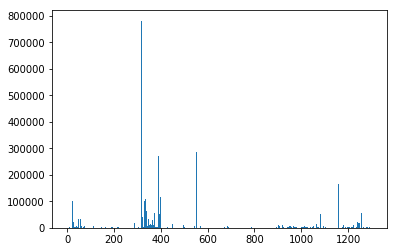

In [107]:
# Statistics for class labels:

allTrainEmoji = []
for i in train['EMOJI_ID'].tolist():
    allTrainEmoji += list(set(i.tolist()))

plt.hist(allTrainEmoji, bins=np.arange(0, len(le.classes_)))




In [108]:
# Counts for each label
counts = Counter(allTrainEmoji)

# 5 most common emojis
mostCommon5 = counts.most_common(5)
print(mostCommon5)

# Original IDs (+2 to refer to CSV mapping) of the most common 5 emojis
originalID = le.inverse_transform([i[0] for i in mostCommon5])
print("originalID: ", originalID)

# average counts
print(sum(counts.values())/len(counts.values()))


[(317, 782111), (329, 302374), (365, 287556), (552, 287442), (390, 269360)]
originalID:  ['1381' '1392' '1424' '186' '1447']
7735.71


In [47]:
# create CSR Matrix based on EMOJI_ID
shape_csr = (len(train), len(le.classes_))

row = []
col = []

row_idx = 0
for c, emoji_ids in enumerate(train.EMOJI_ID.tolist()):
    tempEmoji = set(emoji_ids)
    row += [row_idx] * len(tempEmoji)  
    col += emoji_ids.tolist()
    row_idx += 1
        


7443390

In [109]:
with open('../data/train.pickle', 'wb') as handle:
    pickle.dump(train, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [110]:
trainSuccinct = train[['TEXT_ID', 'EMOJI_ID']]
trainSuccinct.to_csv('../data/train_final_succinct.txt', index=False)



In [111]:
with open('../data/train_succinct.pickle', 'wb') as handle:
    pickle.dump(trainSuccinct, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Try only use top-50 emojis

In [112]:
mostCommon50 = counts.most_common(50)
ID50 = set([i[0] for i in mostCommon50])

with open('../data/train_succinct.pickle', 'rb') as handle:
    trainSuccinct50 = pickle.load(handle)

trainSuccinct50.columns = ['TEXT_ID', 'EMOJI_ID']


In [113]:
trainSuccinct50['EMOJI_ID'] = trainSuccinct50.EMOJI_ID.apply(ID50.intersection)
trainSuccinct50['EMOJI_ID'] = trainSuccinct50['EMOJI_ID'].apply(list)

In [114]:
# verify we have only top 50 codes

temp = set()
for i in trainSuccinct50.EMOJI_ID.tolist():
    temp.update(set(i))

print(len(temp))

50


In [115]:
with open('../data/train_succinct50.pickle', 'wb') as handle:
    pickle.dump(trainSuccinct50, handle, protocol=pickle.HIGHEST_PROTOCOL)

list